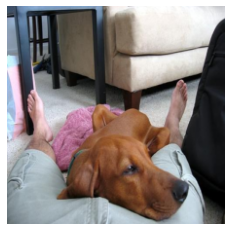

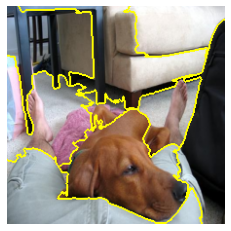

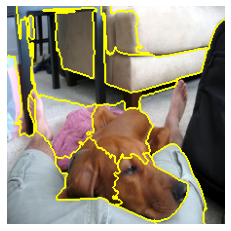

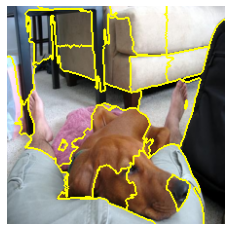

In [63]:
# import the necessary packages
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import torchvision
import torch
import random
import torch.nn as nn
import litdata
from skimage.filters import sobel
from skimage.color import rgb2gray


postprocess = (
    torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)), 
        #torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    nn.Identity(),
    )

train_dataset = litdata.LITDataset(
            "IN1k",
            r"F:\data",
            override_extensions=[
                'jpg',
                'cls'
            ],
            train = True,
        ).map_tuple(*postprocess)

# Load CIFAR-10 dataset
#train_dataset = torchvision.datasets.CIFAR10(root='F:\data', train=True, download=False, transform=torchvision.transforms.Resize((224, 224)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Select a random image from the data loader
random_index = 3#random.randint(0, len(train_dataset) - 1)
image, _ = train_dataset[random_index]

# Convert the image to a floating point data type
image = img_as_float(image)

plt.imshow(image)
plt.axis("off")
plt.show()

gradient = sobel(rgb2gray(image))

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply SLIC and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of SLIC
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

In [57]:
import os, glob
import torch
import numpy as np
import scipy.io
from skimage.color import rgb2lab
import matplotlib.pyplot as plt


def convert_label(label):

    onehot = np.zeros((1, 50, label.shape[0], label.shape[1])).astype(np.float32)

    ct = 0
    for t in np.unique(label).tolist():
        if ct >= 50:
            break
        else:
            onehot[:, ct, :, :] = (label == t)
        ct = ct + 1

    return onehot


class BSDS:
    def __init__(self, root, split="train", color_transforms=None, geo_transforms=None):
        self.gt_dir = r"F:\data\BSDS500\data\ground_truth\train"# os.path.join(root, "BSDS500\\data\\groundTruth", split)
        self.img_dir = r"F:\data\BSDS500\data\images\train" #os.path.join(root, "BSDS500\\data\\images", split)

        self.index = os.listdir(self.gt_dir)

        self.color_transforms = color_transforms
        self.geo_transforms = geo_transforms


    def __getitem__(self, idx):
        idx = self.index[idx][:-4]
        gt = scipy.io.loadmat(os.path.join(self.gt_dir, idx+".mat"))
        t = np.random.randint(0, len(gt['groundTruth'][0]))
        gt = gt['groundTruth'][0][t][0][0][0]

        img = rgb2lab(plt.imread(os.path.join(self.img_dir, idx+".jpg")))

        gt = gt.astype(np.int64)
        img = img.astype(np.float32)

        if self.color_transforms is not None:
            img = self.color_transforms(img)

        if self.geo_transforms is not None:
            img, gt = self.geo_transforms([img, gt])

        gt = convert_label(gt)
        gt = torch.from_numpy(gt)
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)

        return img, gt.reshape(50, -1).float()


    def __len__(self):
        return len(self.index)
    


In [61]:
import os
import torch
import numpy as np
import scipy.io
from skimage.color import rgb2lab
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def convert_label(label):
    onehot = np.zeros((1, 50, label.shape[0], label.shape[1])).astype(np.float32)
    ct = 0
    for t in np.unique(label).tolist():
        if ct >= 50:
            break
        else:
            onehot[:, ct, :, :] = (label == t)
        ct = ct + 1
    return onehot

class ApplyGeometricTransforms:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img, gt):
        # Convert numpy arrays to PIL Images for torchvision transforms
        img = Image.fromarray((img * 255).astype(np.uint8))
        gt = Image.fromarray((gt * 255).astype(np.uint8))

        # Apply the transformation
        img = self.transform(img)
        gt = self.transform(gt)

        # Convert PIL Images back to numpy arrays
        img = np.array(img).astype(np.float32) / 255.0
        gt = np.array(gt).astype(np.int64)

        return img, gt

class BSDS:
    def __init__(self, root, split="train", color_transforms=None, geo_transforms=None):
        self.gt_dir = r"F:\data\BSDS500\data\ground_truth\train"
        self.img_dir = r"F:\data\BSDS500\data\images\train"
        self.index = os.listdir(self.gt_dir)
        self.color_transforms = color_transforms
        self.geo_transforms = geo_transforms

    def __getitem__(self, idx):
        idx = self.index[idx][:-4]
        gt = scipy.io.loadmat(os.path.join(self.gt_dir, idx+".mat"))
        t = np.random.randint(0, len(gt['groundTruth'][0]))
        gt = gt['groundTruth'][0][t][0][0][0]
        img = rgb2lab(plt.imread(os.path.join(self.img_dir, idx+".jpg")))
        gt = gt.astype(np.int64)
        img = img.astype(np.float32)

        if self.color_transforms is not None:
            img = self.color_transforms(img)

        if self.geo_transforms is not None:
            img, gt = self.geo_transforms(img, gt)

        gt = convert_label(gt)
        gt = torch.from_numpy(gt)
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)

        return img, gt.reshape(50, -1).float()

    def __len__(self):
        return len(self.index)

# Define geometric transformations
transform = ApplyGeometricTransforms(transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
]))

# Create dataset
dataset2 = BSDS("path/to/data", geo_transforms=transform)

# Get an item from the dataset
res = dataset2.__getitem__(30)
print(res[1].shape, res[0].shape)

torch.Size([50, 50176]) torch.Size([3, 224, 224])


In [58]:
import torchvision.transforms as transforms

transform = transforms.Compose([
            transforms.Resize((224, 224)),
        ])

dataset2 = BSDS("rrrr", geo_transforms=transform)
res = dataset2.__getitem__(51)
res[1].shape


TypeError: Unexpected type <class 'list'>

In [52]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import torchvision.transforms.functional as F

class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']
        
        # Resize the image
        image = F.resize(image, self.size)
        
        # Resize the masks
        resized_masks = []
        for mask in masks:
            mask_pil = Image.fromarray(mask)
            resized_mask = F.resize(mask_pil, self.size, interpolation=Image.NEAREST)
            resized_masks.append(np.array(resized_mask))
        resized_masks = np.stack(resized_masks, axis=0).astype(np.float32)
        
        return {'image': image, 'masks': resized_masks}

class BSDS500Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.image_dir = os.path.join(root_dir, 'images', split)
        self.anno_dir = os.path.join(root_dir, 'ground_truth', split)
        self.image_paths = sorted([os.path.join(self.image_dir, fname) for fname in os.listdir(self.image_dir) if fname.endswith('.jpg')])
        self.anno_paths = sorted([os.path.join(self.anno_dir, fname) for fname in os.listdir(self.anno_dir) if fname.endswith('.mat')])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        anno_path = self.anno_paths[idx]
        mat = loadmat(anno_path)
        ground_truth = mat['groundTruth'][0]

        boundaries = [gt['Boundaries'][0, 0] for gt in ground_truth]
        masks = np.stack(boundaries, axis=0).astype(np.float32)

        sample = {'image': image, 'masks': masks}

        if self.transform:
            sample = self.transform(sample)

        return sample['image'], sample['masks']


def loadmat(filename):
    import scipy.io
    return scipy.io.loadmat(filename)

resize_transform = ResizeTransform(size=(256, 256))
transform = transforms.Compose([
        resize_transform,
        transforms.Lambda(lambda x: {'image': transforms.ToTensor()(x['image']), 'masks': torch.tensor(x['masks'])}),
    ])
dataset = BSDS500Dataset(root_dir=r"D:\Data\BSDS500\data", split='train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)


In [53]:
import torchvision.transforms as transforms


img, label = dataset.__getitem__(51)
label.shape, img.shape

(torch.Size([6, 256, 256]), torch.Size([3, 256, 256]))

(256, 256)


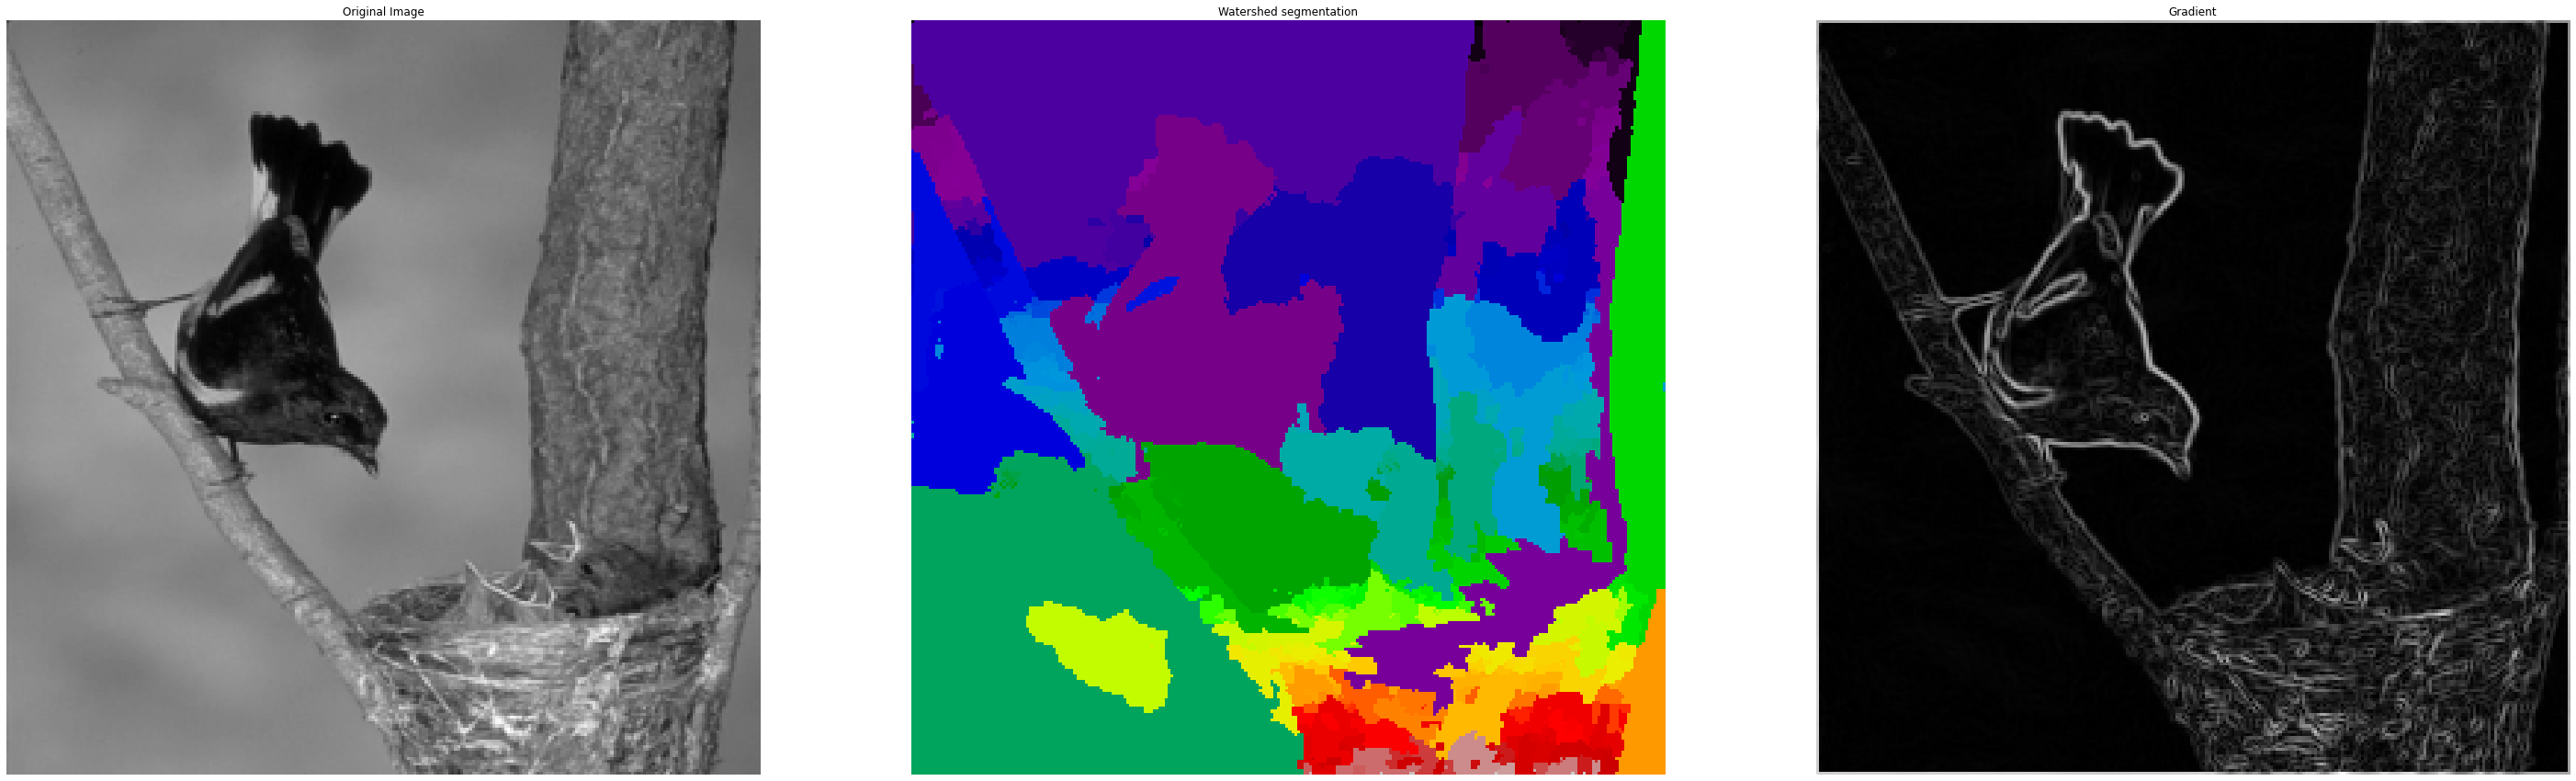

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
import torch
import torch.nn.functional as F


def sobel_filter(image):
    """Instead of fixed sobel kernels can we make the parameters in the kernels learnable? This could let the model learn the optimal edge detection filters"""
    # Convert image to a PyTorch tensor and add batch and channel dimensions
    image = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Define Sobel kernels
    Kx = torch.tensor([[-1, 0, 1], 
                       [-2, 0, 2], 
                       [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    Ky = torch.tensor([[ 1,  2,  1], 
                       [ 0,  0,  0], 
                       [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    # Convolve the image with the Sobel kernels
    Gx = F.conv2d(image, Kx, padding=1)
    Gy = F.conv2d(image, Ky, padding=1)
    
    # Calculate the gradient magnitude
    G = torch.hypot(Gx, Gy)
    
    # Normalize to range [0, 255]
    G = (G / G.max()) * 255
    
    return G.squeeze().detach().numpy().astype(np.uint8)

def generate_binary_structure(rank, connectivity):
    if connectivity < 1:
        connectivity = 1
    if rank < 1:
        return np.array(True, dtype=bool)
    output = np.fabs(np.indices([3] * rank) - 1)
    output = np.add.reduce(output, 0)
    return output <= connectivity

def connected_components(input, structure=None):
    input = np.asarray(input)
    if np.iscomplexobj(input):
        raise TypeError('Complex type not supported')

    if structure is None:
        structure = generate_binary_structure(input.ndim, 1)
    structure = np.asarray(structure, dtype=bool)
    
    if structure.ndim != input.ndim:
        raise RuntimeError('structure and input must have equal rank')
    for ii in structure.shape:
        if ii != 3:
            raise ValueError('structure dimensions must be equal to 3')

    output = np.zeros(input.shape, np.int32)
    label = 1
    max_label = 0

    def flood_fill(x, y, label):
        queue = [(x, y)]
        while queue:
            cx, cy = queue.pop(0)
            if output[cx, cy] == 0 and input[cx, cy]:
                output[cx, cy] = label
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = cx + dx, cy + dy
                    if 0 <= nx < input.shape[0] and 0 <= ny < input.shape[1]:
                        queue.append((nx, ny))

    for i in range(input.shape[0]):
        for j in range(input.shape[1]):
            if input[i, j] and output[i, j] == 0:
                flood_fill(i, j, label)
                label += 1
                max_label = label - 1

    return output, max_label


def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel_filter(image)

    # Generate markers
    """
    these markers is to identifies specific regions in the image that will serve as starting points (seeds) for the watershed algorithm. In traditional watershed segmentation:
    Low-Intensity Markers (1): These typically correspond to the darker regions in the image, which could represent background or specific objects of interest.
    High-Intensity Markers (2): These typically correspond to the brighter regions in the image, which could represent different objects or features of interest.
    
    By using these markers, the watershed algorithm can "flood" the image from these predefined seed points, allowing for more controlled and accurate segmentation of different regions within the image.
    Instead of using percentiles, could we make the placement of the markers learnable instead?
    """
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    """
    The flooding process inherently involves non-differentiable operations like heap-based priority queues. 
    To make this differentiable, we can approximate the process using differentiable operations, 
    such as softmax for computing probabilities of pixel assignments.
    """
    labeled, _ = connected_components(markers)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))
                        
                        


    plt.figure(figsize=(50, 50))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(gradient, cmap='gray')
    plt.title('Gradient')
    plt.axis('off')
    
    plt.show()
    


watershed_from_scratch(img.permute(1, 2, 0))

In [29]:
plt.imshow(label.view(50, img.shape[1], img.shape[2])[2])

TypeError: view() takes from 0 to 2 positional arguments but 3 were given

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


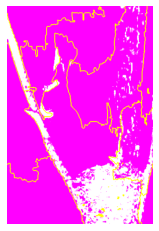

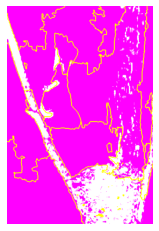

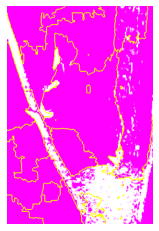

In [65]:
gradient = sobel(rgb2gray(img.permute(1, 2, 0).numpy()))

# Loop over the number of segments
for numMarkers in (10, 20, 30):
    # Apply SLIC and extract (approximately) the supplied number of segments
    segments_watershed = watershed(gradient, markers=numMarkers, compactness=0.001)
    
    # Show the output of SLIC
    fig = plt.figure("Superpixels -- %d numMarkers" % (numMarkers))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(img.permute(1,2,0).numpy(), segments_watershed))
    plt.axis("off")

# Show the plots
plt.show()

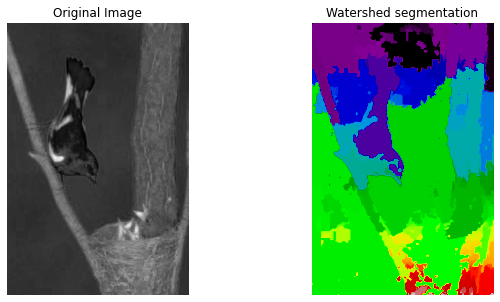

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import sobel

def watershed_from_scratch(image):
    # Convert image to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Compute the gradient magnitude of the image
    gradient = sobel(image)

    # Generate markers
    markers = np.zeros_like(image)
    markers[image < np.percentile(image, 10)] = 1
    markers[image > np.percentile(image, 90)] = 2

    # Simulate flooding process
    from scipy.ndimage import label, generate_binary_structure
    labeled, _ = label(markers)
    
    structure = generate_binary_structure(2, 2)

    import heapq
    heap = []
    for (i, j), value in np.ndenumerate(labeled):
        if value > 0:
            heapq.heappush(heap, (gradient[i, j], i, j, value))
    
    while heap:
        h, i, j, label_val = heapq.heappop(heap)
        for di in range(-1, 2):
            for dj in range(-1, 2):
                ni, nj = i + di, j + dj
                if 0 <= ni < gradient.shape[0] and 0 <= nj < gradient.shape[1]:
                    if labeled[ni, nj] == 0:
                        labeled[ni, nj] = label_val
                        heapq.heappush(heap, (gradient[ni, nj], ni, nj, label_val))


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(labeled, cmap='nipy_spectral')
    plt.title('Watershed segmentation')
    plt.axis('off')
    
    plt.show()


watershed_from_scratch(img.permute(1, 2, 0))

In [71]:
class LearnableSobelFilter(nn.Module):
    def __init__(self):
        super(LearnableSobelFilter, self).__init__()
        # Define the learnable parameters for the Sobel kernels
        self.Kx = nn.Parameter(torch.tensor([[-1, 0, 1], 
                                             [-2, 0, 2], 
                                             [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
        
        self.Ky = nn.Parameter(torch.tensor([[ 1,  2,  1], 
                                             [ 0,  0,  0], 
                                             [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0))

    def forward(self, image):
        # Ensure the input image is a 4D tensor (batch, channel, height, width)
        if len(image.shape) == 2:
            image = image.unsqueeze(0).unsqueeze(0)
        elif len(image.shape) == 3:
            image = image.unsqueeze(0)
        
        # Convolve the image with the learnable Sobel kernels
        Gx = F.conv2d(image, self.Kx, padding=1)
        Gy = F.conv2d(image, self.Ky, padding=1)
        
        # Calculate the gradient magnitude
        G = torch.hypot(Gx, Gy)
        
        return G
    
class LearnableMarkerGenerator(nn.Module):
    def __init__(self, num_markers=3):
        super(LearnableMarkerGenerator, self).__init__()
        self.num_markers = num_markers
        # Define a simple convolutional neural network
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, num_markers, kernel_size=3, padding=1)  # Output channels = num_markers

    def forward(self, image):
        # Ensure the input image is a 4D tensor (batch, channel, height, width)
        if len(image.shape) == 2:
            image = image.unsqueeze(0).unsqueeze(0)
        elif len(image.shape) == 3:
            image = image.unsqueeze(0)
        
        # Pass the image through the network
        x = F.relu(self.conv1(image))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        
        # Apply softmax to get probabilities for each marker
        x = F.softmax(x, dim=1)
        
        # Convert probabilities to marker indices
        markers = torch.argmax(x, dim=1, keepdim=True)
        
        return markers.squeeze()
    
class DifferentiableFlooding(nn.Module):
    def __init__(self, num_markers):
        super(DifferentiableFlooding, self).__init__()
        self.num_markers = num_markers

    def forward(self, gradient, markers):
        # Ensure gradient and markers are 4D tensors
        if len(gradient.shape) == 2:
            gradient = gradient.unsqueeze(0).unsqueeze(0)
        if len(markers.shape) == 2:
            markers = markers.unsqueeze(0).unsqueeze(0)
        
        batch_size, _, height, width = gradient.shape
        
        # Flatten the markers and gradients
        markers_flat = markers.view(batch_size, -1)
        gradient_flat = gradient.view(batch_size, -1)
        
        # Softmax to compute probabilities
        softmax = nn.Softmax(dim=1)
        probs = softmax(-gradient_flat)  # Inverse gradient to simulate heap priority

        # Initialize labeled image with markers
        labeled = markers_flat.clone()
        
        # Iteratively update labels
        for _ in range(height * width):
            # Compute weighted sum of neighbor labels
            neighbor_labels = F.conv2d(labeled.view(batch_size, 1, height, width), 
                                       weight=torch.ones(1, 1, 3, 3).to(labeled.device), 
                                       padding=1)
            neighbor_labels_flat = neighbor_labels.view(batch_size, -1)
            
            # Update labels based on probabilities
            labeled_flat = torch.argmax(probs * neighbor_labels_flat, dim=1, keepdim=True)
            labeled = labeled_flat.view(batch_size, 1, height, width)
        
        return labeled.view(batch_size, height, width)
    
    
class LearnableWatershed(nn.Module):
    def __init__(self, num_markers=3):
        super(LearnableWatershed, self).__init__()
        self.sobel_filter = LearnableSobelFilter()
        self.marker_generator = LearnableMarkerGenerator(num_markers=num_markers)
        self.flooding = DifferentiableFlooding(num_markers=num_markers)

    def forward(self, image):
        gradient = self.sobel_filter(image)
        print(type(gradient))
        markers = self.marker_generator(image)
        labeled = self.flooding(gradient, markers)
        return labeled
    
# Example usage
image = np.random.rand(256, 256)  # Replace with your image data
image_tensor = torch.tensor(image, dtype=torch.float32)

learnable_watershed = LearnableWatershed(num_markers=3)
labeled = learnable_watershed(image_tensor.unsqueeze(0).unsqueeze(0))
print(labeled)

<class 'torch.Tensor'>


RuntimeError: expected scalar type Long but found Float

In [37]:
import time
import torchvision.transforms as transforms
import torch.nn as nn

class LearnableSobelFilter(nn.Module):
    def __init__(self):
        super(LearnableSobelFilter, self).__init__()
        # Define the learnable parameters for the Sobel kernels
        self.Kx = nn.Parameter(torch.tensor([[-1, 0, 1], 
                                             [-2, 0, 2], 
                                             [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0))
        
        self.Ky = nn.Parameter(torch.tensor([[ 1,  2,  1], 
                                             [ 0,  0,  0], 
                                             [-1, -2, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0))

    def forward(self, image):
        # Ensure the input image is a 4D tensor (batch, channel, height, width)
        if len(image.shape) == 2:
            image = image.unsqueeze(0).unsqueeze(0)
        elif len(image.shape) == 3:
            image = image.unsqueeze(0)
        
        # Convolve the image with the learnable Sobel kernels
        Gx = F.conv2d(image, self.Kx, padding=1)
        Gy = F.conv2d(image, self.Ky, padding=1)
        
        # Calculate the gradient magnitude
        G = torch.hypot(Gx, Gy)
        
        return G

class LearnableMarkerGenerator(nn.Module):
    def __init__(self, num_markers=3):
        super(LearnableMarkerGenerator, self).__init__()
        self.num_markers = num_markers
        # Define a simple convolutional neural network
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, num_markers, kernel_size=3, padding=1)  # Output channels = num_markers

    def forward(self, image):
        # Ensure the input image is a 4D tensor (batch, channel, height, width)
        if len(image.shape) == 2:
            image = image.unsqueeze(0).unsqueeze(0)
        elif len(image.shape) == 3:
            image = image.unsqueeze(0)
        
        # Pass the image through the network
        x = F.relu(self.conv1(image))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        
        # Apply softmax to get probabilities for each marker
        x = F.softmax(x, dim=1)
        
        # Convert probabilities to marker indices
        markers = torch.argmax(x, dim=1, keepdim=True)
        
        return markers
    
class DifferentiableFloodingProcess(nn.Module):
    def __init__(self, num_classes, num_iterations=10):
        super(DifferentiableFloodingProcess, self).__init__()
        self.num_classes = num_classes
        self.num_iterations = num_iterations
    
    def forward(self, gradient, markers):
        b, c, h, w = gradient.size()
        
        # Ensure markers are one-hot encoded
        markers_one_hot = F.one_hot(markers.squeeze(1), num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        # Initialize the labeled image with markers
        labeled = markers_one_hot.clone()
        
        for _ in range(self.num_iterations):
            # Compute the affinity between neighboring pixels
            affinity = F.avg_pool2d(labeled, kernel_size=3, stride=1, padding=1)
            
            # Update the labels using softmax for differentiability
            labeled = F.softmax(affinity + gradient, dim=1)
        
        # Convert the labeled tensor to final segmentation by taking the argmax
        labeled = torch.argmax(labeled, dim=1, keepdim=True)
        
        return labeled


class LearnableWatershed(nn.Module):
    def __init__(self, num_markers=3):
        super(LearnableWatershed, self).__init__()
        self.sobel_filter = LearnableSobelFilter()
        self.marker_generator = LearnableMarkerGenerator(num_markers=num_markers)
        self.flooding_process = DifferentiableFloodingProcess(num_classes=num_markers)
        self.grayscale_transform = transforms.Grayscale(num_output_channels=1)

    def forward(self, image):
        if image.shape[1] == 3:  # assuming image shape is (batch_size, channels, height, width)
            image = self.grayscale_transform(image)
        # Compute gradient magnitude using the learnable Sobel filter
        gradient = self.sobel_filter(image)

        # Generate markers using the learnable marker generator
        markers = self.marker_generator(image)

        # Perform the differentiable flooding process
        segmentation = self.flooding_process(gradient, markers)
        return segmentation

# Usage example
learnable_watershed = LearnableWatershed(num_markers=50)
segmentation = learnable_watershed(img.unsqueeze(0))
print(segmentation.shape)

torch.Size([1, 1, 256, 256])
